# Getting rid of root at infinity
**Adapted from**: Section~2.2.1 p. 33 of [D13]

[D13] Dreesen, Philippe.
*Back to the Roots: Polynomial System Solving Using Linear Algebra*
Ph.D. thesis (2013)

In [1]:
using LinearAlgebra
using TypedPolynomials
using MacaulayMatrix
using JuMP
using MultivariateMoments

Consider the system given in [D13, (2.3)] which corresponds to `Systems/dreesen2` of [macaulaylab](http://www.macaulaylab.net/):

In [2]:
@polyvar x y z
system = [
    x^2 - x*y + z,
    2y^3 - 2x*y^2 - 3x * y,
    z^3 - x*y*z - 2,
]

3-element Vector{MultivariatePolynomials.VectorPolynomial{Int64, MultivariatePolynomials.Term{Int64, TypedPolynomials.Monomial{(x, y, z), 3}}}}:
 z - xy + x²
 -3xy + 2y³ - 2xy²
 -2 + z³ - xyz

We first try to solve the system:

In [3]:
sols = solve_system(system, column_maxdegree = 6)
nothing # hide

[ Info: Added 6 rows to complete columns up to degree 3
[ Info: Nullspace of dimensions (14, 8) computed from Macaulay matrix of dimension (6, 14) in 8.3686e-5 seconds.
[ Info: Added 12 rows to complete columns up to degree 4
[ Info: Nullspace of dimensions (33, 15) computed from Macaulay matrix of dimension (18, 33) in 0.000144459 seconds.
[ Info: Added 22 rows to complete columns up to degree 5
[ Info: Nullspace of dimensions (56, 18) computed from Macaulay matrix of dimension (40, 56) in 0.000339343 seconds.
[ Info: Added 35 rows to complete columns up to degree 6
[ Info: Nullspace of dimensions (84, 18) computed from Macaulay matrix of dimension (75, 84) in 0.000844305 seconds.
[ Info: Found 1 real solution


The real solutions are

In [4]:
sols

1-element Vector{Vector{Float64}}:
 [3.842056017511342, 4.995671506251089, 4.4322553304068]

## Staicase analysis

In [5]:
solver = Iterator(system, MacaulayMatrix.Solver())
step!(solver)

[ Info: Added 6 rows to complete columns up to degree 3
[ Info: Nullspace of dimensions (14, 8) computed from Macaulay matrix of dimension (6, 14) in 5.895e-5 seconds.


We can look at the solver as follows:

In [6]:
solver

MacaulayMatrix matrix solver. Last iteration considered:
6×14 Macaulay matrix for polynomials:
  z - x*y + x^2
  -3*x*y + 2*y^3 - 2*x*y^2
  -2 + z^3 - x*y*z
The row shifts are:
MonomialBasis([1, z, y, x])
The column basis is:
MonomialBasis([1, z, z^2, y*z, x*z, x*y, x^2, z^3, y^3, x*y*z, x*y^2, x^2*z, x^2*y, x^3])
BorderBasis with independent rows and dependent columns in:
BasisDependence for bases:
 Standard:
 MonomialBasis([1, z, z^2, y*z, x*z, x*y, z^3, y^3])
 Trivial Standard:
 MonomialBasis([y, x, y^2, y*z^2, y^2*z, x*z^2, z^4, y*z^3, y^2*z^2, y^3*z, y^4, x*z^3])
 Corners:
 MonomialBasis([x^2, x*y*z, x*y^2])
 Trivial Independent Border:
 MonomialBasis([x*y*z^2, x*y^2*z, x*y^3, x^2*z^2])
 Dependent Border:
 MonomialBasis([x^2*z, x^2*y])

And entries in a 8×5 adjoint(::Matrix{Float64}) with eltype Float64:
  4.159065386202991e-16   -1.9999999999999998      …  -1.9069420129706838e-16
 -1.0                     -3.1080979595180984e-16      4.5135339788020976e-17
  1.1499638451679124e-1

We can see in the border dependence that even if `x^2` is a corner, the multiplication
matrix for `x` cannot be computed as `y^3` (resp. `x*z^2`, `y*z^2`) is standard but
`x * y^3` (resp. `x^2 * z^2`, `x * y * z^2`) is indepedent.

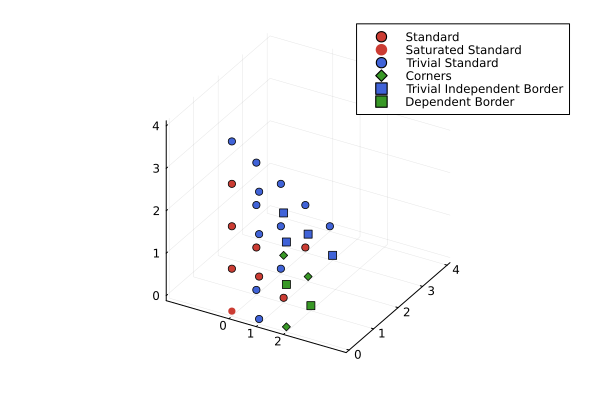

In [7]:
using Plots
plot(saturated_dependence(solver))

Let's do another step:

In [8]:
step!(solver)

[ Info: Added 12 rows to complete columns up to degree 4
[ Info: Nullspace of dimensions (33, 15) computed from Macaulay matrix of dimension (18, 33) in 0.000136915 seconds.


This time, the blocker for computing the multiplication matrix for `x`
are `z^4` and `y * z^3` among others.

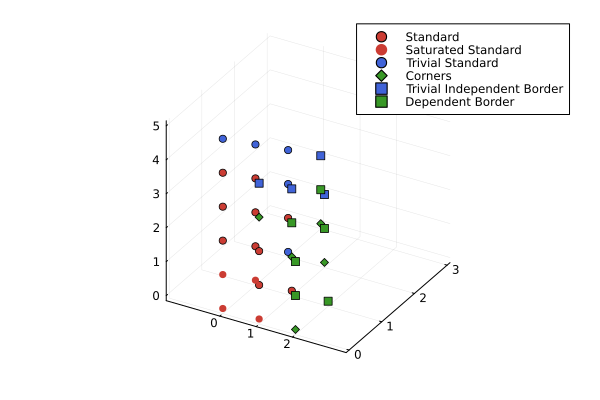

In [9]:
plot(saturated_dependence(solver))

Let's do another step:

In [10]:
step!(solver)

[ Info: Added 22 rows to complete columns up to degree 5
[ Info: Nullspace of dimensions (56, 18) computed from Macaulay matrix of dimension (40, 56) in 0.000356175 seconds.


Now they are `z^5` and `y * z^4` among others.

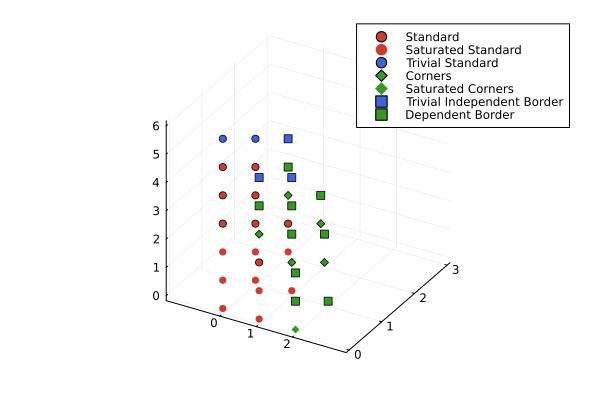

In [11]:
plot(saturated_dependence(solver))

Let's do a last step:

In [12]:
step!(solver)

[ Info: Added 35 rows to complete columns up to degree 6
[ Info: Nullspace of dimensions (84, 18) computed from Macaulay matrix of dimension (75, 84) in 0.000907092 seconds.
[ Info: Found 1 real solution


Now we see that the whole border is dependent so the four
multiplication matrices can be computed.

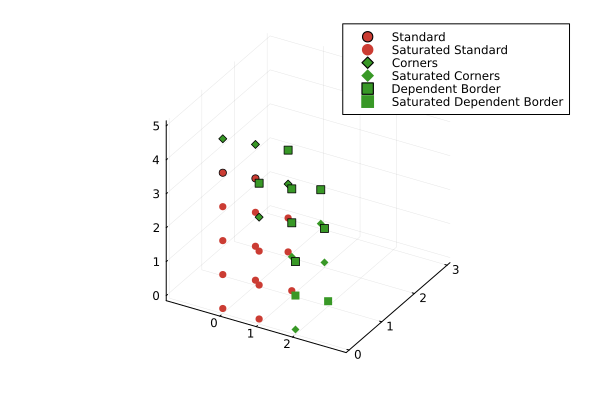

In [13]:
plot(saturated_dependence(solver))

In retrospect, we we probably should have expanded in priority towards larger
exponents for `z`.

### Saturation

Let's start again by starting with the same first stop.

In [14]:
solver = Iterator(system, MacaulayMatrix.Solver())
step!(solver)

[ Info: Added 6 rows to complete columns up to degree 3
[ Info: Nullspace of dimensions (14, 8) computed from Macaulay matrix of dimension (6, 14) in 4.6056e-5 seconds.


This time, let's focus on saturating the first
non-saturated standard monomials:

In [15]:
step!(solver, FirstStandardNonSaturated(10))

[ Info: Added 12 rows to saturate columns `TypedPolynomials.Monomial{(x, y, z), 3}[z, y, x, z², yz, y², xz, xy, z³, yz²]`
[ Info: Nullspace of dimensions (38, 20) computed from Macaulay matrix of dimension (18, 38) in 0.000142856 seconds.


We can see that `z` is now saturated:

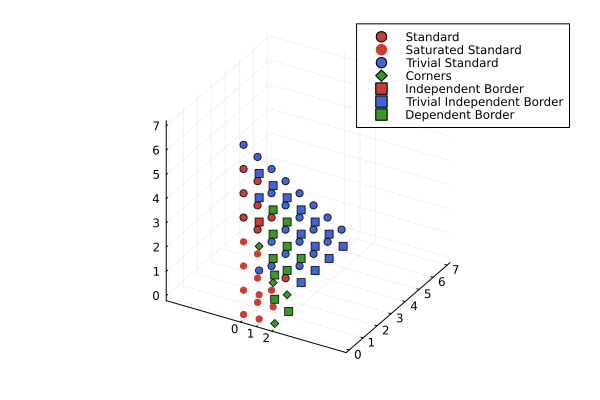

In [16]:
plot(saturated_dependence(solver))

Let's saturate the next one:

In [17]:
step!(solver, FirstStandardNonSaturated(10))

[ Info: Added 20 rows to saturate columns `TypedPolynomials.Monomial{(x, y, z), 3}[y²z, y³, xz², z⁴, yz³, y²z², y³z, y⁴, z⁵, yz⁴]`
[ Info: Nullspace of dimensions (70, 32) computed from Macaulay matrix of dimension (38, 70) in 0.000354692 seconds.


We can see that `y` went from trivial to saturated:

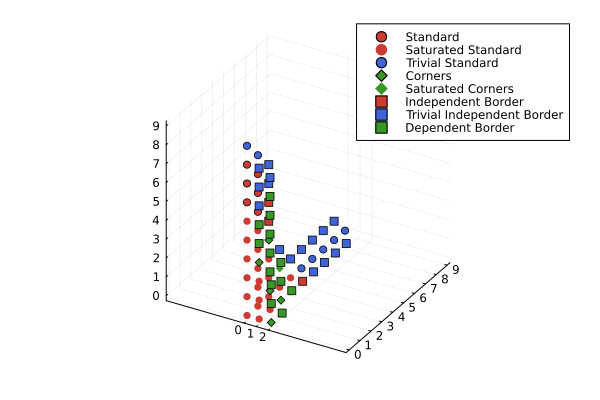

In [18]:
plot(saturated_dependence(solver))

Let's saturate the next one:

In [19]:
step!(solver, FirstStandardNonSaturated(10))

[ Info: Added 20 rows to saturate columns `TypedPolynomials.Monomial{(x, y, z), 3}[y⁵, z⁶, yz⁵, y⁶, z⁷, yz⁶, y⁷, z⁸, yz⁷, y⁸]`
[ Info: Nullspace of dimensions (103, 45) computed from Macaulay matrix of dimension (58, 103) in 0.000744168 seconds.


We can see that `x` went from trivial to saturated:

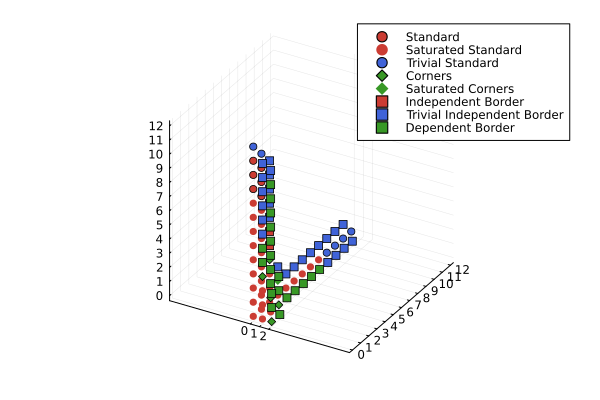

In [20]:
plot(saturated_dependence(solver))

Let's saturate the next one:

In [21]:
step!(solver, FirstStandardNonSaturated(10))

[ Info: Added 20 rows to saturate columns `TypedPolynomials.Monomial{(x, y, z), 3}[z⁹, yz⁸, y⁹, z¹⁰, yz⁹, y¹⁰, z¹¹, yz¹⁰, y¹¹, z¹²]`
[ Info: Nullspace of dimensions (136, 58) computed from Macaulay matrix of dimension (78, 136) in 0.001964106 seconds.


We can see that `z^2` is now saturated:

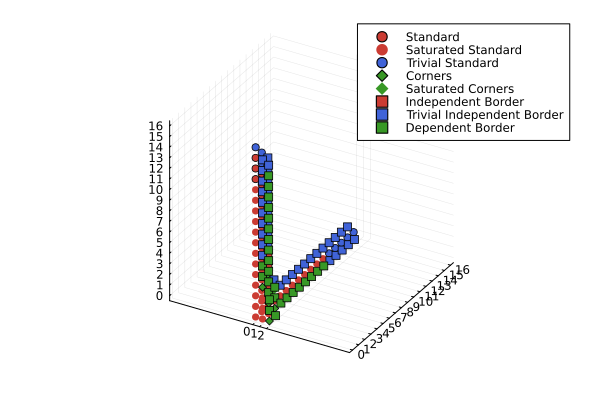

In [22]:
plot(saturated_dependence(solver))

We can see that this does not seem to work.
By saturating a monomial,
we generate all the rows that have a nonzero entry for the corresponding
column in the MacaulayMatrix matrix.
If the monomial is standard, it means that the column is a linear combination of other columns
(which are dependent in the MacaulayMatrix Nullspace)
of the MacaulayMatrix matrix.
If we saturate these other columns, the linear combination may not work anymore.
But we are only saturating the standard monomials, we don't saturate
the rows that are dependent in the MacaulayMatrix Nullspace which explains
the result we have seen here.

## Moment approach

With moment matrix of degree 3:

In [23]:
import Clarabel
solver = Clarabel.Optimizer

M = moment_matrix(system, solver, 3)
nothing # hide

atomic_measure(M, 1e-4, ShiftNullspace())

[ Info: Nullspace of dimensions (14, 8) computed from Macaulay matrix of dimension (6, 14) in 6.5943e-5 seconds.
-------------------------------------------------------------
           Clarabel.jl v0.9.0  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 11
  constraints   = 11
  nnz(P)        = 0
  nnz(A)        = 67
  cones (total) = 2
    : Zero        = 1,  numel = 1
    : PSDTriangle = 1,  numel = 10

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilibrate: 

With moment matrix of degree 4:

In [24]:
M = moment_matrix(system, solver, 4)
nothing # hide

atomic_measure(M, 1e-4, ShiftNullspace())

[ Info: Nullspace of dimensions (33, 15) computed from Macaulay matrix of dimension (18, 33) in 0.000147495 seconds.
-------------------------------------------------------------
           Clarabel.jl v0.9.0  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 17
  constraints   = 56
  nnz(P)        = 0
  nnz(A)        = 784
  cones (total) = 2
    : Zero        = 1,  numel = 1
    : PSDTriangle = 1,  numel = 55

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilibr

With moment matrix of degree 5:

In [25]:
M = moment_matrix(system, solver, 5)
nothing # hide

atomic_measure(M, 1e-4, ShiftNullspace())

[ Info: Nullspace of dimensions (56, 18) computed from Macaulay matrix of dimension (40, 56) in 0.000335607 seconds.
-------------------------------------------------------------
           Clarabel.jl v0.9.0  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 18
  constraints   = 56
  nnz(P)        = 0
  nnz(A)        = 1008
  cones (total) = 2
    : Zero        = 1,  numel = 1
    : PSDTriangle = 1,  numel = 55

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilib

Atomic measure on the variables x, y, z with 1 atoms:
 at [3.84205516042132, 4.99567052245059, 4.432254383584636] with weight 0.9999998706390161

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*